In [2]:
import pandas as pd
import numpy as np
from math import pow
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
from sklearn.metrics import r2_score
from ipywidgets import IntProgress
import scipy.optimize as opt
from scipy import integrate

In [3]:
df = pd.read_csv("Data/Grim/data.csv", index_col=0)
def rrc3_pressure_conversion_function_ft(press_kpa):
    pressure = press_kpa * 10
    altitude = (1 - pow(pressure / 1_013.25, 0.190284)) * 145_366.45
    return altitude


def ft_to_meters(ft): return ft * 0.3048

In [4]:
boost_end = 3_500
first_charge = 28_125
altim = df[['pressure (kPa)']].copy()
altim['alt_m_asl'] = altim['pressure (kPa)'].map(rrc3_pressure_conversion_function_ft).map(ft_to_meters)
altim['alt_m_agl'] = altim['alt_m_asl'] - altim['alt_m_asl'].min()

Text(0.5, 1.0, 'Measured Altimeter Altitude')

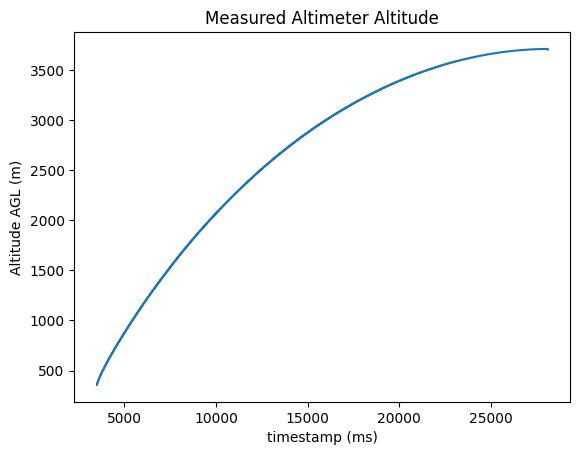

In [5]:
fig = altim.loc[boost_end:first_charge]['alt_m_agl'].plot()
fig.set_ylabel("Altitude AGL (m)")
fig.set_title("Measured Altimeter Altitude")        

In [6]:
nice_data = altim.loc[boost_end:first_charge].copy()
nice_data.index = nice_data.index.to_series() / 1000.0
nice_data.index.set_names("timestamp", inplace=True)
nice_data['t'] = nice_data.index

In [7]:
actual_apogee, actual_apogee_index = nice_data['alt_m_agl'].max(), nice_data['alt_m_agl'].argmax() 
actual_apogee_time = nice_data.iloc[actual_apogee_index].t
print(actual_apogee, actual_apogee_time)

3712.8837039159207 28.056


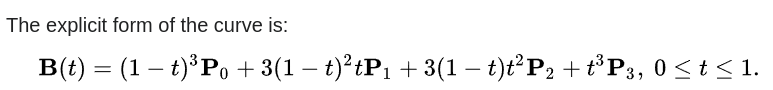

In [8]:
p0 = np.array([3.502, 356.325308])
p1 = np.array([6, 1400])
p2 = np.array([15, 3706.951794])
p3 = np.array([28.123, 3706.951794])

In [9]:
def b(t, p0, p1, p2, p3):
    print("t=",t)
    # print(t, p0, p1, p2, p3)
    return pow(1-t, 3) * p0 + 3*pow(1-t,2) * t* p1 + 3*(1-t) * pow(t, 2) * p2 + pow(t, 3) * p3

In [10]:
def bx(t, p0x, p0y, p1x, p1y, p2x, p2y, p3x, p3y):
    return ((1-t) ** 3) * p0x + 3*((1-t)**2) * t* p1x + 3*(1-t) * (t**2) * p2x + (t**3) * p3x 

def by(t, p0x, p0y, p1x, p1y, p2x, p2y, p3x, p3y):
    return ((1-t) ** 3) * p0y + 3*((1-t)**2) * t* p1y + 3*(1-t) * (t**2) * p2y + (t**3) * p3y 

In [11]:
xs = np.linspace(0, 1, 200)
ys = by(xs, p0[0], p0[1], p1[0], p1[1], p2[0], p2[1], p3[0], p3[1])
x2s = bx(xs, p0[0], p0[1], p1[0], p1[1], p2[0], p2[1], p3[0], p3[1])

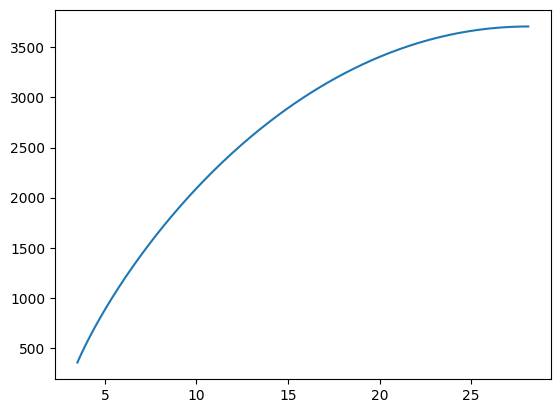

In [12]:
plt.plot(x2s, ys)

Initial Definition
$$B(t) = (1-t)^3 P_0 + 3(1-t)^2tP_1 + 3(1-t)t^2P_2 + t^3P_3, \ 0 \leq t \leq 1$$

$t = 1$ is apogee

$t_f = $ apogee time in seconds

$s = $ time since boost end in seconds

$t = \frac s {t_f}$


Known:
- $P_0$ we know from our initial position
- $P_{3y} = P_{2y}$. Apogee has 0 velocity, derivative of altitude is 0
- $P_{3x} = t_f$ by the construction of the problem

Expand out
$$B(t) = (-t^3  + 3t^2 -3t + 1)P_0 + 3(t^3-2t^2+t)P_1 + 3(t^2-t^3)P_2 + t^3 P_3, \ 0 \leq t \leq 1$$

Break into components
$$B(t) = (-t^3  + 3t^2 -3t + 1)P_{0x} + 3(t^3-2t^2+t)P_{1x} + 3(t^2-t^3)P_{2x} + t^3 P_{3x}, \ 0 \leq t \leq 1$$
$$B(t) = (-t^3  + 3t^2 -3t + 1)P_{0y} + 3(t^3-2t^2+t)P_{1y} + 3(t^2-t^3)P_{2y} + t^3 P_{3y}, \ 0 \leq t \leq 1$$

Let $t_{f}$ be time of apogee (unknown)

https://www.jimherold.com/computer-science/best-fit-bezier-curve

In [13]:
def b2(s, tf, p0x, p0y, p1x, p1y, p2x, p2y):
    return by(s/tf, p0x,p0y, p1x, p1y, p2x, p2y, tf, p2y)

In [14]:
from scipy.optimize import curve_fit

In [15]:
args, extra = curve_fit(b2, nice_data.index.to_series(), nice_data['alt_m_agl'].to_numpy())

/tmp/ipykernel_470431/3352732673.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  args, extra = curve_fit(b2, nice_data.index.to_series(), nice_data['alt_m_agl'].to_numpy())


In [16]:
args

array([1.05681908e+11, 1.00000000e+00, 2.68718707e+03, 1.00000000e+00,
       1.95681923e+02, 1.00000000e+00, 9.41575205e+01])

In [17]:
def b_fill(x):
    return b2(x, *args)

<Axes: xlabel='timestamp'>

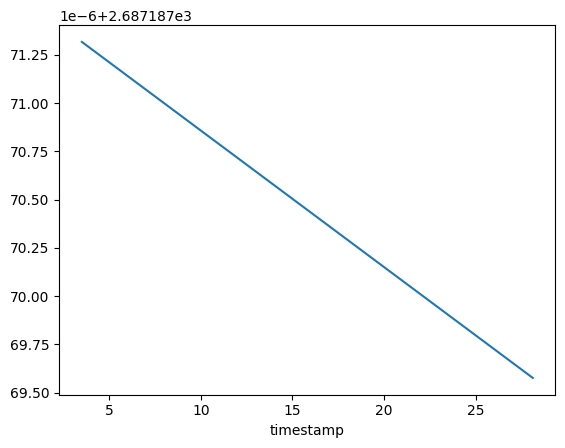

In [18]:
b_fill(nice_data.index.to_series()).plot()

In [19]:
xs = np.linspace(0,1,200)

In [20]:
bdf = pd.DataFrame([b(t, p0, p1, p2, p3) for t in xs ], columns = ['time', 'alt']).set_index('time')

t= 0.0
t= 0.005025125628140704
t= 0.010050251256281407
t= 0.01507537688442211
t= 0.020100502512562814
t= 0.02512562814070352
t= 0.03015075376884422
t= 0.035175879396984924
t= 0.04020100502512563
t= 0.04522613065326633
t= 0.05025125628140704
t= 0.05527638190954774
t= 0.06030150753768844
t= 0.06532663316582915
t= 0.07035175879396985
t= 0.07537688442211056
t= 0.08040201005025126
t= 0.08542713567839195
t= 0.09045226130653267
t= 0.09547738693467336
t= 0.10050251256281408
t= 0.10552763819095477
t= 0.11055276381909548
t= 0.11557788944723618
t= 0.12060301507537688
t= 0.12562814070351758
t= 0.1306532663316583
t= 0.135678391959799
t= 0.1407035175879397
t= 0.1457286432160804
t= 0.15075376884422112
t= 0.15577889447236182
t= 0.16080402010050251
t= 0.1658291457286432
t= 0.1708542713567839
t= 0.17587939698492464
t= 0.18090452261306533
t= 0.18592964824120603
t= 0.19095477386934673
t= 0.19597989949748745
t= 0.20100502512562815
t= 0.20603015075376885
t= 0.21105527638190955
t= 0.21608040201005024
t= 0.22

<Axes: xlabel='timestamp'>

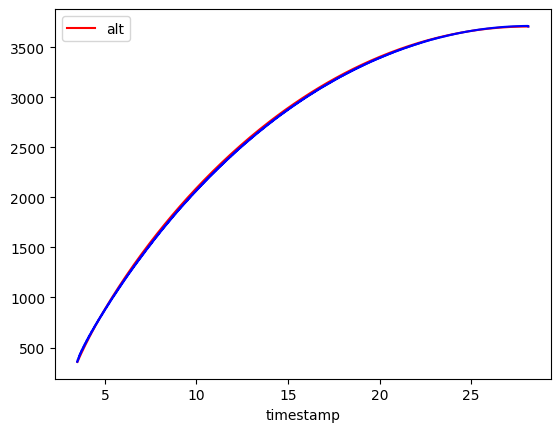

In [21]:
bdf.plot(color='red')
nice_data['alt_m_agl'].plot(color='blue')

In [22]:
def Q(t, p0x, p0y, p1x, p1y, p2x, p2y):
    x = p1x + np.pow((1-t), 2) * (p0x - p1x) + np.pow(t, 2) * (p2x - p1x)
    y = p1y + np.pow((1-t), 2) * (p0y - p1y) + np.pow(t, 2) * (p2y - p1y)
    return x, y
    

In [23]:
p0 = np.array([3.502, 356.325308])
p1 = np.array([6, 1400])
p2 = np.array([13.5, 3706.951794])
p3 = np.array([28.123, 3706.951794])

In [26]:
xs = np.linspace(0, 1, 200)
oxs, oys = b(xs, p0, p1, p2, p3)

t= [0.         0.00502513 0.01005025 0.01507538 0.0201005  0.02512563
 0.03015075 0.03517588 0.04020101 0.04522613 0.05025126 0.05527638
 0.06030151 0.06532663 0.07035176 0.07537688 0.08040201 0.08542714
 0.09045226 0.09547739 0.10050251 0.10552764 0.11055276 0.11557789
 0.12060302 0.12562814 0.13065327 0.13567839 0.14070352 0.14572864
 0.15075377 0.15577889 0.16080402 0.16582915 0.17085427 0.1758794
 0.18090452 0.18592965 0.19095477 0.1959799  0.20100503 0.20603015
 0.21105528 0.2160804  0.22110553 0.22613065 0.23115578 0.2361809
 0.24120603 0.24623116 0.25125628 0.25628141 0.26130653 0.26633166
 0.27135678 0.27638191 0.28140704 0.28643216 0.29145729 0.29648241
 0.30150754 0.30653266 0.31155779 0.31658291 0.32160804 0.32663317
 0.33165829 0.33668342 0.34170854 0.34673367 0.35175879 0.35678392
 0.36180905 0.36683417 0.3718593  0.37688442 0.38190955 0.38693467
 0.3919598  0.39698492 0.40201005 0.40703518 0.4120603  0.41708543
 0.42211055 0.42713568 0.4321608  0.43718593 0.44221106 0.447

TypeError: only length-1 arrays can be converted to Python scalars

<Axes: xlabel='timestamp'>

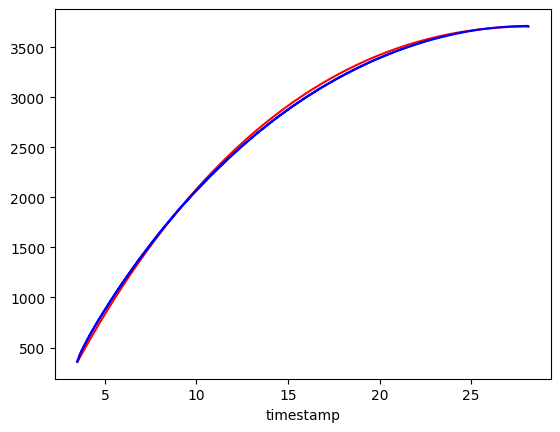

In [ ]:
plt.plot(oxs, oys, color='red')
nice_data['alt_m_agl'].plot(color='blue')